In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.transforms.v2 as v2
from torchmetrics.functional import pairwise_cosine_similarity

import numpy as np
import pandas as pd
import math
from pathlib import Path
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor
import random
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import sys

sys.path.append('./src')
from src.data import MultiSet, multi_collate, ImageTransforms, SignalTransforms
from src.module import TS_Transformer, ImageEncoder, BiModal, CLIP

from torch.utils.tensorboard import SummaryWriter
from accelerate import Accelerator
from accelerate.utils import GradientAccumulationPlugin

import scienceplots
plt.style.use('science')

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": 12
})

%matplotlib widget

In [97]:
data_path = Path('./data/CytoSense')

image_transforms = ImageTransforms()
signal_transforms = SignalTransforms(max_len=256)

In [106]:
id = 15

train_set = MultiSet(data_path=data_path, annotation_file=f'train_{id}.csv', 
                   image_transforms=v2.Compose([
                    image_transforms, v2.ColorJitter(0.5, 0.5)
                   ]),
                   signal_transforms=signal_transforms,
                   image_size=(224, 224))

test_set = MultiSet(data_path=data_path, annotation_file=f'test_{id}.csv', 
                    image_transforms=image_transforms,
                    signal_transforms=signal_transforms,
                    image_size=(224, 224))

valid_set = MultiSet(data_path=data_path, annotation_file=f'valid_{id}.csv', 
                    image_transforms=image_transforms,
                    signal_transforms=signal_transforms,
                    image_size=(224, 224))
                    
test_set.label_encoder = train_set.label_encoder
valid_set.label_encoder = train_set.label_encoder

In [142]:
bs = 32

train_loader = DataLoader(dataset=train_set, batch_size=bs, 
                        shuffle=True, num_workers=8, 
                        drop_last=True, collate_fn=multi_collate)

test_loader = DataLoader(dataset=test_set, batch_size=bs, 
                         num_workers=8, collate_fn=multi_collate)

valid_loader = DataLoader(dataset=valid_set, batch_size=bs, 
                         num_workers=8, collate_fn=multi_collate)

In [145]:
len(train_loader), len(valid_loader)

(23, 5)

(2002, tensor(0.4357))

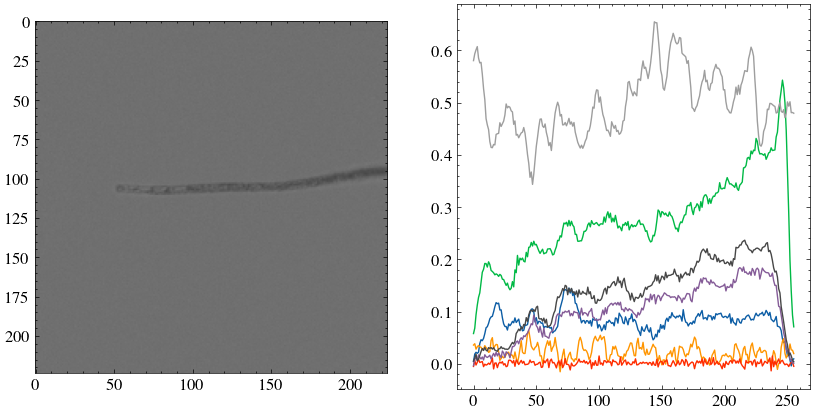

In [112]:
ix = 0

image, signal, y = train_set[ix]

fig, ax = plt.subplots(1, 2)

ax[0].imshow(image.permute(1, 2, 0))
ax[1].plot(signal)

fig.set_size_inches(10, 5)

train_set.X[ix], (image).mean()

## Cross-Modality Training

In [169]:
signal_encoder = TS_Transformer(dim_in=7, dim_out=256, num_head=8, num_layers=6,
                         dim_feedforward=1024, max_len=256)

image_encoder = ImageEncoder('resnet18')

model = BiModal(image_encoder, signal_encoder, 128)

criterion = CLIP()
parameters = list(model.parameters()) + list(criterion.parameters())
optimizer = optim.Adam(parameters, lr=1e-5, weight_decay=1e-10)

plugin = GradientAccumulationPlugin(num_steps=1, sync_with_dataloader=False)
accelerator = Accelerator(mixed_precision='fp16', gradient_accumulation_plugin=plugin)

model, criterion, optimizer, train_loader, test_loader, valid_loader = accelerator.prepare(
    model, criterion, optimizer, train_loader, test_loader, valid_loader)

model

BiModal(
  (model_1): ImageEncoder(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Bat

In [170]:
def step(model, criterion, batch):
    image, signal, _ = batch
    out = model(image, signal)
    loss = criterion(*out)
    return loss

In [171]:
epochs = 20
steps = len(train_loader) * epochs
iterator = tqdm(range(1, steps + 1))

generator = iter(train_loader)

accum_steps = accelerator.gradient_accumulation_steps
accumulated_loss = 0

writer = SummaryWriter()

model.train()
criterion.train()

for i in iterator:

    try:
        batch = next(generator)
    except StopIteration:
        generator = iter(train_loader)
        batch = next(generator)

    with accelerator.accumulate(model, criterion):
        optimizer.zero_grad()
        loss = step(model, criterion, batch)
        accelerator.backward(loss)
        optimizer.step()
        accumulated_loss += loss.detach().item()

    if i % accum_steps == 0:
        accumulated_loss /= accum_steps
        model.eval()
        criterion.eval()
        with torch.no_grad():
            valid_loss = sum(step(model, criterion, batch).cpu().item() \
                             for batch in valid_loader) / len(valid_loader)
        writer.add_scalar('Loss/train:', accumulated_loss, i // accum_steps)
        writer.add_scalar('Loss/validation:', valid_loss, i // accum_steps)
        accumulated_loss = 0
        model.train()
        criterion.train()


100%|██████████| 460/460 [07:54<00:00,  1.03s/it]


In [156]:
model.eval()
criterion.eval()

I_e = []
S_e = []
label = []
losses = []

with torch.no_grad():
    for image, signal, y in tqdm(test_loader):
        encoding_1, encoding_2 = model(image, signal)
        loss = criterion(encoding_1, encoding_2)
        losses.append(loss.cpu().item())
        I_e.append(encoding_1.cpu())
        S_e.append(encoding_2.cpu())
        label.append(y.cpu())

I_e = torch.cat(I_e)
S_e = torch.cat(S_e)
label = torch.cat(label)

print(f'{np.mean(losses) = }')

100%|██████████| 168/168 [00:07<00:00, 23.83it/s]

np.mean(losses) = np.float64(3.43880481947036)


In [162]:
I_e_np = I_e.numpy()
S_e_np = S_e.numpy()
label_np = label.numpy()

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

E = TSNE(2, perplexity=20, early_exaggeration=20).fit_transform(S_e_np)
# E = PCA(2).fit_transform(S_e_np + I_e_np)

In [163]:
logits = I_e_np @ S_e_np.T
logits.argmax(0)

array([   9, 1059, 1059, ..., 4922, 3149, 4922], shape=(5365,))

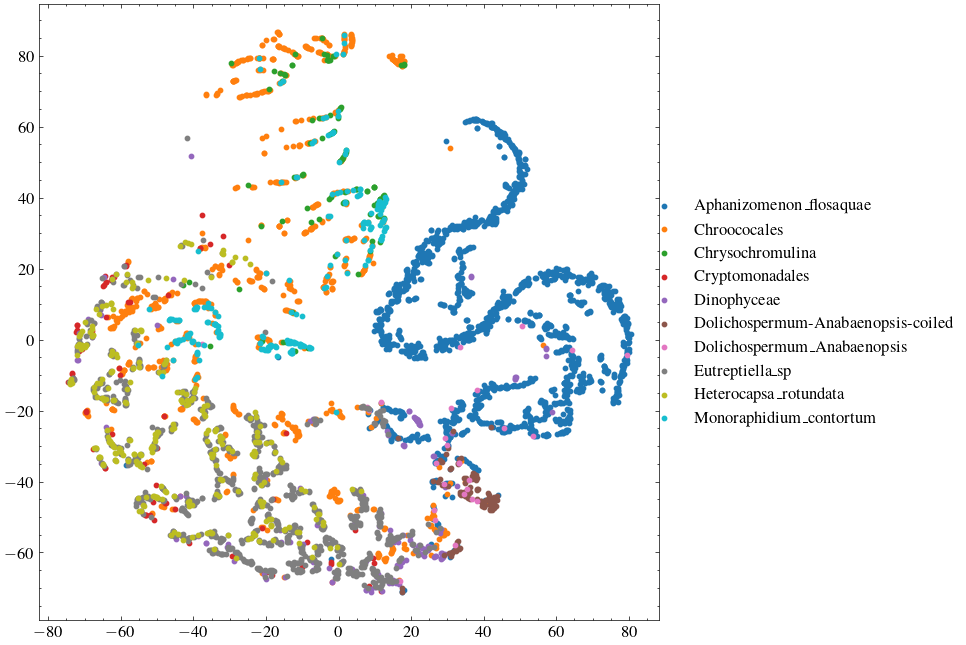

In [164]:
fig = plt.figure()
ax = fig.add_subplot()#projection='3d')

for y, c in zip(np.unique(label_np), mcolor.TABLEAU_COLORS.values()):
    class_name = test_set.label_encoder.inverse_transform([y])[0]
    e = E[label == y]
    ax.scatter(*zip(*e), label=class_name, s=10, c=c)

fig.set_size_inches(8, 8)
ax.legend(loc=7, bbox_to_anchor=(1.5, .5))
plt.show()

## Training the classifier

In [131]:
classifier = nn.Sequential(
    nn.Linear(128, 4096),
    nn.GELU(),
    nn.Linear(4096, 4096),
    nn.GELU(),
    nn.Linear(4096, 5)
)

criterion = nn.CrossEntropyLoss()
parameters_new = parameters + list(classifier.parameters())
optimizer = optim.Adam(parameters, lr=1e-5, weight_decay=1e-10)
classifier, optimizer = accelerator.prepare(classifier, optimizer)

losses = []

In [ ]:
epochs = 10
steps = len(train_loader) * epochs
iterator = tqdm(range(1, steps + 1))

generator = iter(dataloader)

model.train()
classifier.train()
accumulated_loss = 0
accum_steps = accelerator.gradient_accumulation_steps

writer = SummaryWriter()

for i in iterator:

    try:
        batch = next(generator)
    except StopIteration:
        generator = iter(train_loader)
        batch = next(generator)

    with accelerator.accumulate(model, classifier):
        optimizer.zero_grad()
        encoding_1, encoding_2 = model(*batch[:-1])
        out 
        accelerator.backward(loss)
        optimizer.step()
        accumulated_loss += loss.detach().item()

    if i % accum_steps == 0:
        accumulated_loss /= accum_steps
        model.eval()
        criterion.eval()
        with torch.no_grad():
            valid_loss = sum(step(model, criterion, batch).cpu().item() \
                             for batch in valid_loader) / len(valid_loader)
        writer.add_scalar('Loss/train:', accumulated_loss, i // accum_steps)
        writer.add_scalar('Loss/validation:', valid_loss, i // accum_steps)
        accumulated_loss = 0




In [ ]:
clip.eval()

I_e = []
S_e = []
label = []
test_losses = []

for image, signal, y in tqdm(test_loader):
    with torch.no_grad():
        encoding_1, encoding_2, loss = clip(image, signal)
        I_e.append(encoding_1.cpu())
        S_e.append(encoding_2.cpu())
        label.append(y.cpu())
        test_losses.append(loss.detach().item())

I_e = torch.cat(I_e)
S_e = torch.cat(S_e)
label = torch.cat(label)

print(f'Loss = {np.mean(test_losses)}')

In [ ]:
I_e_np = I_e.numpy()
S_e_np = S_e.numpy()
label_np = label.numpy()

from sklearn.manifold import TSNE

E = TSNE(2, perplexity=20, early_exaggeration=20).fit_transform(I_e_np + S_e_np)

In [ ]:
fig, ax = plt.subplots()

for y, c in zip(np.unique(label_np), mcolor.TABLEAU_COLORS.values()):
    class_name = test_set.label_encoder.inverse_transform([y])[0]
    e = E[label == y]
    ax.scatter(*zip(*e), label=class_name, s=10, c=c)


fig.set_size_inches(8, 8)
ax.legend(loc=7, bbox_to_anchor=(1.5, .5))
plt.show()

In [ ]:
x = (I_e + S_e).div(2).to(accelerator.device)

with torch.no_grad():
    pred = classifier(x).cpu().argmax(1)

pred


In [ ]:
from sklearn.metrics import classification_report

names = test_set.label_encoder.inverse_transform(list(range(5)))
pd.DataFrame(classification_report(label, pred, target_names=names, output_dict=True)).T

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots()
cm = confusion_matrix(label, pred, normalize='true')
ConfusionMatrixDisplay(cm, display_labels=names).plot(xticks_rotation=90, ax=ax)
fig.set_size_inches(6, 6)

